In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
import numpy as np

df = pd.read_hdf('C:\\Users\\vishw\\SIH\\ml\\ETA Prediction\\Data\\METR-LA.h5')
df.index = df.index.astype(str)
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df.info()
df = df.replace(0, np.nan)
df = df.interpolate(method='time', limit_direction='both')
df = df.bfill().ffill()





<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34272 entries, 2012-03-01 00:00:00 to 2012-06-27 23:55:00
Columns: 207 entries, 773869 to 769373
dtypes: float64(207)
memory usage: 54.4 MB


In [2]:
values = df.values
def make_data(data, input_step=12, predict_step=3):
    x, y = [], []
    for i in range(len(data) - input_step - predict_step):
        past_window = data[i: i + input_step]
        future_point = data[i + input_step + predict_step -1]
        x.append(past_window)
        y.append(future_point)
    return np.array(x), np.array(y)    

In [3]:
#Baseline
traffic = df.copy()
traffic['hour'] = traffic.index.hour
traffic['dow'] = traffic.index.dayofweek
baseline_table = traffic.groupby(['dow', 'hour']).mean()
def baseline_predict(timestamp):
    dow = timestamp.dayofweek
    hour = timestamp.hour
    return baseline_table.loc[(dow, hour)].values

In [4]:
#Evaluation 
errors = []
timestamp = df.index[15:]
for ts in timestamp:
    true = df.loc[ts].values
    predicted = baseline_predict(ts)
    errors.append(np.abs(true - predicted))
mae = np.mean(errors)
mae

np.float64(4.340070705990096)

In [5]:
#Model Training 
x, y = make_data(values)
print(x.shape, y.shape)
X_flat = x.reshape(x.shape[0], -1)
X_flat.shape

split = int(len(X_flat) * 0.8)
x_train, x_val = X_flat[:split], X_flat[split:]
y_train, y_val = y[:split], y[split:]

(34257, 12, 207) (34257, 207)


In [6]:
sensor_idx = 0
y_single_train = y_train[:, sensor_idx]
y_single_val   = y_val[:, sensor_idx]


In [21]:
model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    device="cuda",
    random_state=42
)

model.fit(x_train, y_single_train)

pred = model.predict(x_val)


# Evaluate on validation

Baseline MAE: ~10.7 mph

XGBoost MAE: ~2.4 mph

The machine learning model significantly improves short-term traffic speed prediction, especially during dynamic traffic conditions such as congestion buildup and recovery.

In [8]:

def train_sensor(sensor_idx):
    y_single_train = y_train[:, sensor_idx]
    y_single_val   = y_val[:, sensor_idx]

    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method="hist",
        device="cuda",
        random_state=42
    )

    model.fit(x_train, y_single_train)

    pred = model.predict(x_val)
    mae = np.mean(np.abs(pred - y_single_val))

    return mae


In [9]:
def speed_to_eta(speed_mph, segment_km=5.0):
    speed_kmh = speed_mph * 1.609
    return(segment_km / speed_kmh)*60
true_eta = speed_to_eta(y_single_val)
pred_eta = speed_to_eta(pred)
eta_mae = np.mean(np.abs(true_eta - pred_eta))
eta_mae


np.float64(0.28738004586998284)

In [10]:
input_steps = 12
predict_steps = 3

target_start = input_steps + predict_steps - 1

all_target_times = df.index[target_start:-1]
val_target_times = all_target_times[split:]
len(val_target_times) == len(y_single_val)
len(val_target_times), len(y_single_val)


(6852, 6852)

# Baseline ETA

In [11]:

baseline_speeds = []

for ts in val_target_times:
    pred_all = baseline_predict(ts)
    baseline_speeds.append(pred_all[sensor_idx])

baseline_speeds = np.array(baseline_speeds)
baseline_eta = speed_to_eta(baseline_speeds)
baseline_eta_mae = np.mean(np.abs(true_eta - baseline_eta))
baseline_eta_mae



np.float64(0.4921718856913489)

# Comparision for segment length 0.8km



Baseline ETA MAE = 0.0787 minutes

ML ETA MAE = 0.0460 minutes


# Comparision for segment length 5 km

Baseline ETA MAE = 0.4921

ML ETA MAE = 0.2873

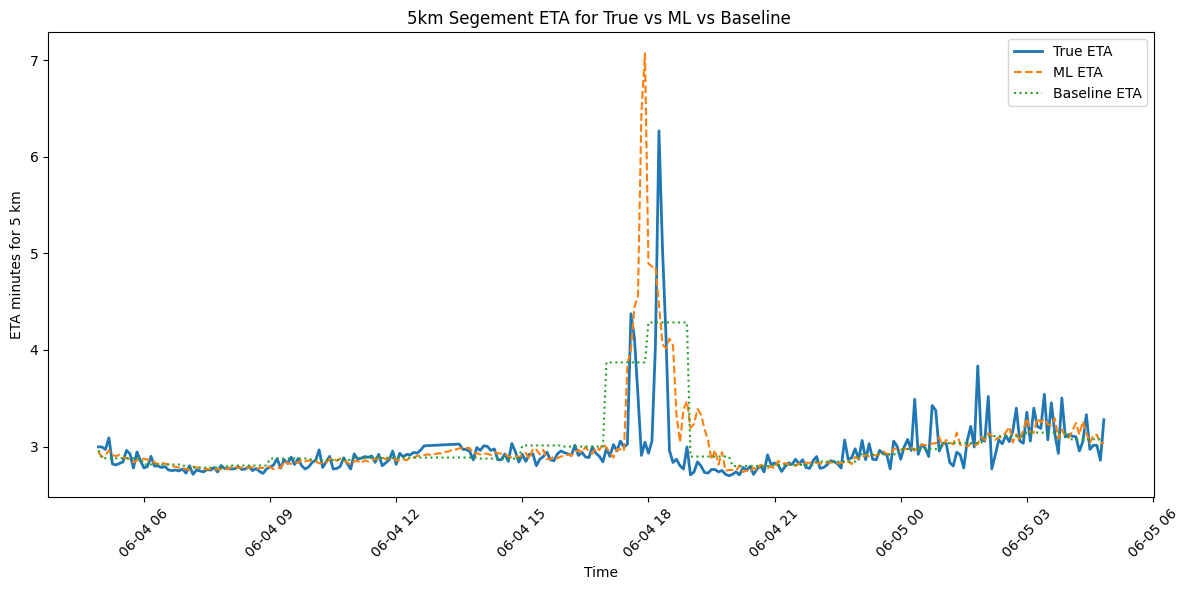

In [12]:

start = 0
end = 288
t = val_target_times[start:end]
true_eta_plot = true_eta[start:end]
ml_eta_plot = pred_eta[start:end]
baseline_eta_plot = baseline_eta[start:end]

plt.figure(figsize=(12, 6))

plt.plot(t, true_eta_plot, label="True ETA", linewidth=2)
plt.plot(t, ml_eta_plot, label="ML ETA", linestyle="--")
plt.plot(t, baseline_eta_plot, label="Baseline ETA", linestyle=":")
plt.ylabel('ETA minutes for 5 km')
plt.xlabel('Time')
plt.title('5km Segement ETA for True vs ML vs Baseline ')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Route ETA
Since METR-LA does not provide road connectivity
So, a synthetic sequence of sensors are used to simulate a realistic multi segment highway trip for ETA evaluation.

In [13]:
route_sensors = ['773869', '717445', '765604', '716960', '772151', '717508']
route_idx = [df.columns.get_loc(s) for s in route_sensors]
true_route_speeds = y_val[:, route_idx]


# ML predicted speeds

In [14]:
preds_route = []

for idx in route_idx:
    model = XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        device='cuda',
        random_state=42
    )
    model.fit(x_train, y_train[:, idx])
    preds_route.append(model.predict(x_val))

preds_route = np.stack(preds_route, axis=1)



In [15]:
baseline_speeds_all = []
for ts in val_target_times:
    baseline_speeds_all.append(baseline_predict(ts))
baseline_speeds_all = np.array(baseline_speeds_all)
baseline_speeds_all.shape

baseline_route_speeds = baseline_speeds_all[:, route_idx]


In [16]:
def route_eta(speeds):
    return np.sum(speed_to_eta(speeds, segment_km=5.0), axis=1)

true_route_eta = route_eta(true_route_speeds)
ml_route_eta = route_eta(preds_route)
baseline_route_eta = route_eta(baseline_route_speeds)

#route level MAE
ml_route_mae = np.mean(np.abs(true_route_eta - ml_route_eta))
baseline_route_mae = np.mean(np.abs(true_route_eta - baseline_route_eta))
baseline_route_mae

np.float64(2.812567640989095)

# Uncertainty

In [17]:
segment_std = []
for i, idx in enumerate(route_idx):
    error = np.abs(true_route_speeds[:, i ] - preds_route[:, i])
    segment_std.append(np.std(error))
segment_std = np.array(segment_std)
segment_std

array([4.06801308, 4.14366515, 2.25920354, 4.94532417, 5.14548188,
       4.56081827])

In [18]:
segment_eta_std = []

for i in range(len(route_idx)):
    speeds = true_route_speeds[:, i]
    dV = segment_std[i]
    
    speeds_kmh = speeds * 1.609
    dV_kmh = dV * 1.609
    
    eta_std = np.mean((5 / (speeds_kmh**2)) * dV_kmh * 60)
    segment_eta_std.append(eta_std)

segment_eta_std = np.array(segment_eta_std)
segment_eta_std


array([0.36500751, 0.35779044, 0.11843097, 0.56258217, 0.58552713,
       0.49553927])

In [19]:
route_uncertainty = np.sqrt(np.sum(segment_eta_std**2))
route_uncertainty

np.float64(1.0863564169416464)

So for the 30 km route the predicted time travel is uncertain 
by about: <mark>~ 1 minute</mark>

# Route ETA with Uncertainty Bands

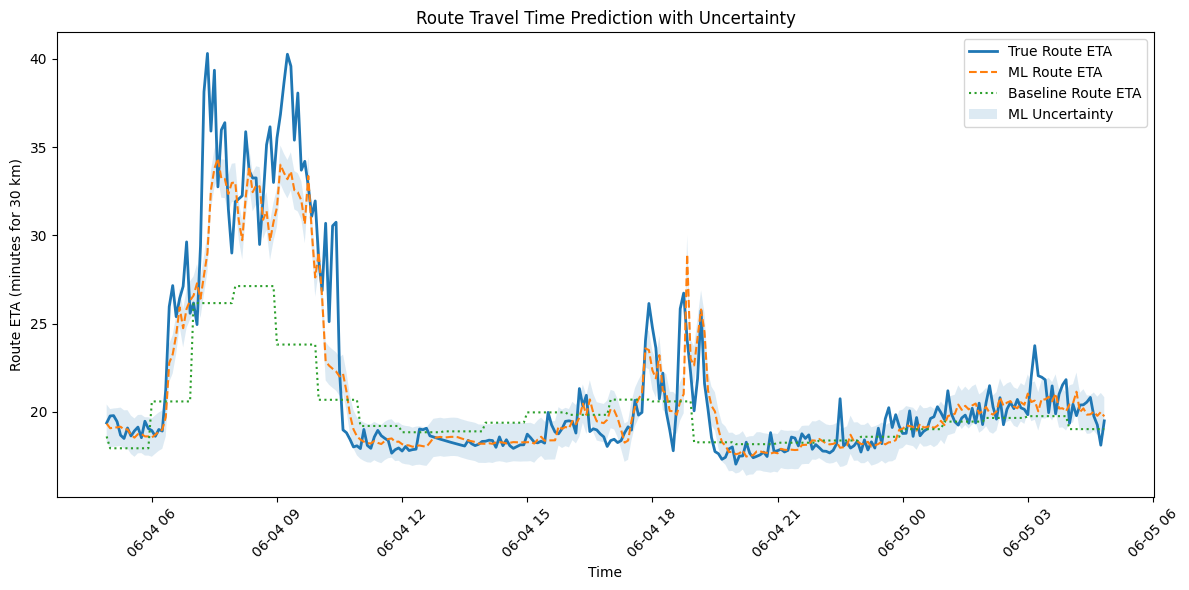

In [20]:


start, end = 0, 288

t = val_target_times[start:end]
true_plot = true_route_eta[start:end]
ml_plot = ml_route_eta[start:end]
base_plot = baseline_route_eta[start:end]
unc = route_uncertainty

plt.figure(figsize=(12,6))
plt.plot(t, true_plot, label="True Route ETA", linewidth=2)
plt.plot(t, ml_plot, label="ML Route ETA", linestyle="--")
plt.plot(t, base_plot, label="Baseline Route ETA", linestyle=":")

plt.fill_between(t, ml_plot-unc, ml_plot+unc, alpha=0.15, label="ML Uncertainty")

plt.ylabel("Route ETA (minutes for 30 km)")
plt.xlabel("Time")
plt.title("Route Travel Time Prediction with Uncertainty")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
